In [0]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers, reporter
from chainer import Link, Chain, ChainList
from chainer.dataset import convert
from chainer.dataset import iterator as iterator_module
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

from matplotlib import pyplot as plt
import cupy as cp

import itertools

In [0]:
train, test = datasets.get_mnist(withlabel=True, ndim=2)

In [0]:
train_images, train_labels = train._datasets[0],train._datasets[1]
test_images, test_labels = test._datasets[0],test._datasets[1]
del(train)
del(test)


In [4]:
if chainer.cuda.available:
  xp = cp
else:
  xp = np

anchor_images = np.empty((1,28,28)).astype(np.float32)
training_images = np.empty((1,10,28,28)).astype(np.float32)
for i in range(10):
  if i == 0:
    class_i_images = train_images[np.random.choice(np.where(train_labels == i)[0],11)] #Sample 11 images of class i
    to_anchor, to_train = class_i_images[-1], class_i_images[:-1]
    anchor_images[i] = to_anchor.reshape(1,28,28)
    training_images[i] = to_train.reshape(1,10,28,28)
  else:
    class_i_images = train_images[np.random.choice(np.where(train_labels == i)[0],11)]
    to_anchor, to_train = class_i_images[-1], class_i_images[:-1]
    to_anchor = to_anchor.reshape(1,28,28)
    to_train = to_train.reshape(1,10,28,28)
    
    anchor_images = np.vstack((anchor_images, to_anchor))
    training_images = np.vstack((training_images, to_train)) 
print(anchor_images.shape)
print(training_images.shape)

(10, 28, 28)
(10, 10, 28, 28)


In [0]:
class SiameseNetwork(Chain):

    def __init__(self):
        super(SiameseNetwork, self).__init__(
            conv1=L.Convolution2D(1, 20, ksize=5, stride=1),
            conv2=L.Convolution2D(20, 50, ksize=5, stride=1),
            fc3=L.Linear(800, 500),
            fc4=L.Linear(500, 10),
            fc5=L.Linear(10, 2),
        )

    def single_forward(self, x_data, train=True):
        x = Variable(x_data)
        x = F.reshape(x, (-1,1,28,28))
        
        h = F.max_pooling_2d(self.conv1(x), ksize=2, stride=2)
        h = F.max_pooling_2d(self.conv2(h), ksize=2, stride=2)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        y = self.fc5(h)

        return y

    def __call__(self, anchor_img, pos_img, neg_img, train=True):
        anchor_encoding = self.single_forward(anchor_img)
        pos_img_encoding = self.single_forward(pos_img)
        neg_img_encoding = self.single_forward(neg_img)
        

        return (anchor_encoding, pos_img_encoding, neg_img_encoding)



epoch no:  0   loss:  9.723875
epoch no:  1   loss:  5.457358
epoch no:  2   loss:  1.2836628
epoch no:  3   loss:  0.405927
epoch no:  4   loss:  0.24726214
epoch no:  5   loss:  0.13040859
epoch no:  6   loss:  0.07559173
epoch no:  7   loss:  0.097175986
epoch no:  8   loss:  0.24120624
epoch no:  9   loss:  0.02868101


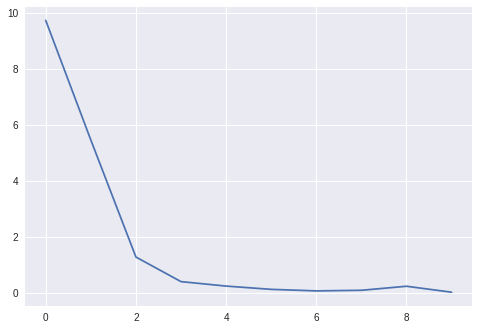

In [6]:
my_model = SiameseNetwork()
my_model.to_gpu()

optimizer = optimizers.SGD()
optimizer.setup(my_model)

epoch_losses = []
validation_accuracy = []
for epoch in range(10):
  epoch_loss = 0
  for pos_id,neg_id in itertools.combinations(range(10),2):
    for pos_image in training_images[pos_id]:
      anchor = anchor_images[pos_id]
      batch_anchor = cp.asarray(np.repeat(np.reshape(anchor,(-1,28,28)),10,axis=0))
      
      
      batch_pos_image = cp.asarray(np.repeat(cp.reshape(pos_image,(-1,28,28)),10,axis=0))
      batch_neg_image = cp.asarray(training_images[neg_id])
      
   
      anchor_encoding, pos_img_encoding, neg_img_encoding = my_model(batch_anchor, 
                                                                 batch_pos_image,
                                                                 batch_neg_image)
      
      my_model.cleargrads()
      loss = F.triplet(anchor_encoding, pos_img_encoding, neg_img_encoding)
      epoch_loss += loss
      loss.backward()
      optimizer.update()
  
  print("epoch no: ",epoch,"  loss: ", epoch_loss.data)
  epoch_losses.append(epoch_loss.data)
      
plt.plot(epoch_losses)      
      
      
    
    
  
  

In [0]:
def predict(image, model):
  sample_output = model.single_forward(cp.asarray(train_images[0])).data
  anchor_outputs = model.single_forward(cp.asarray(anchor_images)).data
  
  sample_output = cp.repeat(sample_output,10,axis=0)
  diff = sample_output - anchor_outputs
  diff_sq = diff**2
  
  return cp.asnumpy(cp.argmin(cp.sum(diff_sq,axis =1)))
